
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [1]:
import time
import math

import pandas as pd

from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *


Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
imputation_method = 'Univariate'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [2]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [3]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [4]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [5]:
start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

# start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
# 
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [6]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [7]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [8]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [9]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [10]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [11]:
tickers

Index(['AAPL', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEP', 'AFL', 'AIG',
       ...
       'WFC', 'WHR', 'WMT', 'WST', 'WY', 'X', 'XRAY', 'XRX', 'ZBRA', 'ZION'],
      dtype='object', length=286)

In [25]:
#Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs
#investor preferences (static throughout the backtest)
k = 6*20 #estimation
alpha= 1 - 0.985 #estimation
return_premium = 1.7 #optimization
cardinality_ratio = 0.05 #optimization
turnover_limit = 1 # 0.75, 1, 1.25
MipGap = 0.05
limit_time = 30

target_return_strategy = ticker_return_target
target_return_strategy_args = ['ticker_index']

q = 1
C = 10**(-3)
epsilon = 10**(-3)
ticker_str = 'AAPL'
ticker_index = tickers.get_loc(ticker_str)


investor_preferences = {'k':k, #horizon
                        'alpha':alpha, #
                        'premium':return_premium,
                        'ticker_index':ticker_index, 'turnover_limit':turnover_limit,
                        'cardinality_ratio': cardinality_ratio,
                        'MipGap' : MipGap, 'limit_time':limit_time,
                        'target_return_strategy':target_return_strategy,
                        'target_return_strategy_args': target_return_strategy_args}

Strategy = general_strategy(exponential_weighted_estimator, CardMVOTurnover,
                            investor_preferences = investor_preferences)

Strategy.extract_estimation_info = populate_exponential_weighted_estimator
# 
Strategy.extract_optimization_info = populateCardMVOTurnover

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [26]:
# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=2)

#End of the first investment period
#testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [27]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 1998-12-31 00:00:00
Test End 1999-05-31 00:00:00
Calibration End 1998-12-30 00:00:00


In [28]:
# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

In [29]:
# Number of assets
n  = len(tickers)
env.n = n

# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

#Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    #take the last available contextual observations
    period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
    period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
    period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

    env.periodReturns = periodReturns
    env.periodFactRet = periodFactRet
    env.period_daily_adjClose = period_daily_adjClose
    env.period_Context = period_Context
    #there should be a feature vector for each asset
    assert len(period_Context) == n

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]
            #update the previous periods portfolio 
        env.previous_portfolio = x0[:,t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    #----------------------------------------------------------------------
    # add in the estimation info

    x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);
    
    #Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum(np.abs( x[:,t] - x0[:,t] ) )

    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)

    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)
    

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

Set parameter TimeLimit to value 30
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 289 rows, 572 columns and 1430 nonzeros
Model fingerprint: 0x263d7d5e
Model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+01]
Presolve time: 0.01s
Presolved: 289 rows, 572 columns, 1430 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Found heuristic solution: objective 0.0669750

Root relaxation: objective 1.708642e-02, 92 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

# 3. Results

In [30]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
Ret = 12*((portfExRets + 1).apply(gmean, axis=0) - 1)
Vol = (12**0.5)*(portfExRets.std())
SR = (12**0.5)*(((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std())

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Annualized return: ', str(Ret[0]))
print('Annualized vol: ', str(Vol[0]))
print('Annualized Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))

Elasped time is 100.7779426574707 seconds
Annualized return:  0.17036101248647828
Annualized vol:  0.17356821292211608
Annualized Sharpe ratio:  0.9815219596858039
Avg. turnover:  1.0050807642870383


### Observations

        The end to end strategy has the following stats when we use 15 observations:
        Elasped time is 27.749337434768677 seconds
        Sharpe ratio:  0.36926056542515073
        Avg. turnover:  0.2846570354951544

        Standard MVO has the following stats when we use 15 observations::
        
        Elasped time is 1.1906468868255615 seconds
        Sharpe ratio:  0.35584233976844887
        Avg. turnover:  0.6967647038270909

        The end to end strategy has the following stats when we use 35 observations:
        
        Elasped time is 16.95100688934326 seconds
        Sharpe ratio:  0.33129478714103455
        Avg. turnover:  0.13229814142751284

        Standard MVO has the following stats when we use 35 observations:
        
        Elasped time is 1.2436742782592773 seconds
        Sharpe ratio:  0.2997765726515852
        Avg. turnover:  0.25328429647155937


In [31]:
value_target_index = initialVal*(1 + adjClose.pct_change(1).loc[portfValue.index, ticker_str]).cumprod()
portfValue[ticker_str] = value_target_index
portfValue.columns = ['Strategy', ticker_str]

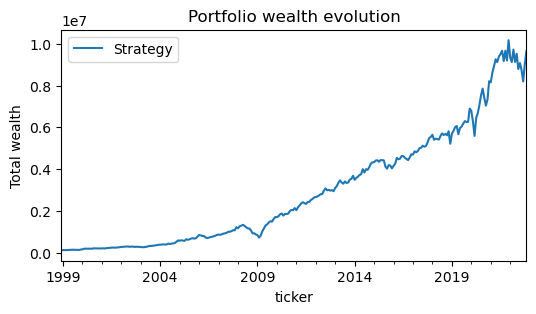

<Figure size 640x480 with 0 Axes>

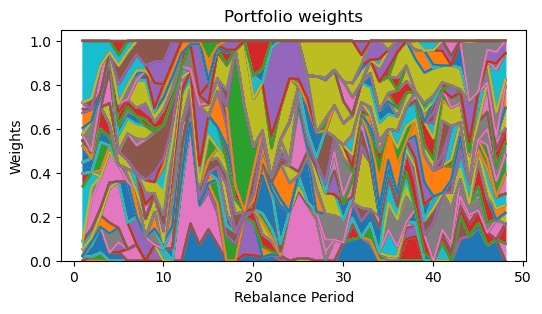

In [32]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.iloc[:,0].plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = True)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
if n <= 20:
    legend_bool = True
else:
    legend_bool = False
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = legend_bool, stacked = True)
if legend_bool:
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%

In [21]:
weights.iloc[:,-1][weights.iloc[:,-1] > 0.001]

AMD     0.078109
AMGN    0.226201
ATVI    0.132746
KR      0.124138
NEM     0.118600
PFE     0.172491
TJX     0.042898
TSCO    0.104816
Name: 48, dtype: float64

In [22]:
(np.abs(daily_adjClose.diff().dropna()) <= 0.001).sum().sort_values()

IBM      26
AMGN     37
KLAC     37
ADBE     39
CAT      39
       ... 
TYL     355
RAD     364
ODFL    429
VHI     470
SIG     527
Length: 286, dtype: int64

In [23]:
# Calculate the portfolio Sharpe ratio
ticker_rets = adjClose.pct_change(1).iloc[1:,]
ticker_rets = ticker_rets.loc[portfRets.index]

tickerExRets = ticker_rets.subtract(riskFree[(riskFree.index >= ticker_rets.index[0])&(riskFree.index <= ticker_rets.index[-1])], axis = 0)

tickerSR = ((tickerExRets + 1).apply(gmean, axis=0) - 1)/tickerExRets.std()

In [24]:
(12**0.5)*tickerSR.sort_values(ascending=False)

UNH     0.769529
ODFL    0.686024
CHD     0.682472
AZO     0.651169
ROL     0.642475
          ...   
AIG    -0.160984
XRX    -0.207712
PBI    -0.214084
UIS    -0.297995
RAD    -0.337033
Length: 286, dtype: float64